In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
a = jnp.ones((16,256,256,3))
del a # To prevent tensorflow from using GPU
import jax.lax as lax

import optax as opt
import numpy as np

from tqdm import tqdm

from functools import partial
from typing import Optional, Sequence, Any

import tensorflow as tf
import tensorflow_datasets as tfds
tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt

Pytree = Any

2023-07-31 22:06:19.964978: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.6 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2023-07-31 22:06:21.267121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dslisleedh/miniconda3/envs/flax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@jax.jit
def p_theta(z: jnp.ndarray, params: Pytree) -> jnp.ndarray:
    """
    Generate x from z.
    Z is q_phi(z|x) when train, but since there's KL between q_phi(z|x) and p_theta(z) in loss function,
    we can use p_theta(z) to generate x when inference.
    """
    for w, b in params:
        z = z @ w + b
    
    return jnp.reshape(z, (-1, 28, 28, 1))


@jax.jit
def q_phi(x: jnp.ndarray, params: Pytree) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Generate z from x.
    """
    x  = jnp.reshape(x, (-1, 28 * 28))
    
    for w, b in params[:-1]:
        x = x @ w + b
    
    mu_w, mu_b, sigma_w, sigmb_b = params[-1]
    mu = x @ mu_w + mu_b
    logvar = x @ sigma_w + sigmb_b

    return mu, logvar


@jax.jit
def reparametrize(mu: jnp.ndarray, logvar: jnp.ndarray, rng: jax.random.PRNGKey) -> jnp.ndarray:
    """
    Reparametrize trick.
    Replace z ~ N(mu, sigma) with z = mu + sigma * eps, eps ~ N(0, 1).
    """
    eps = jax.random.normal(rng, shape=mu.shape)
    return mu + jnp.exp(.5 * logvar) * eps


@jax.jit
def vae(
    x: jnp.ndarray, params: Pytree, rng: jax.random.PRNGKey
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    VAE model
    """
    params_q_phi, params_p_theta = params
    
    mu, logvar = q_phi(x, params_q_phi)
    z = reparametrize(mu, logvar, rng)
    x_hat = p_theta(z, params_p_theta)
    
    return x_hat, mu, logvar


@jax.jit
def sample(z: jnp.ndarray, params: Pytree) -> jnp.ndarray:
    """
    Generate x from z.
    """
    q_phi_params, p_theta_params = params
    return p_theta(z, p_theta_params)

In [3]:
@jax.jit
def reconstruction_loss(x: jnp.ndarray, x_hat: jnp.ndarray) -> jnp.ndarray:
    log_p = jax.nn.sigmoid(x_hat)
    neg_log_p = jax.nn.sigmoid(-x_hat)
    return -jnp.mean(x * jnp.log(log_p) + (1 - x) * jnp.log(neg_log_p)) * 1000.  # For faster training

@jax.jit
def kl_divergence_analytic(mu: jnp.ndarray, logvar: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean(
        -0.5 * jnp.sum(1. + logvar - mu**2 - jnp.exp(logvar), axis=-1)
    ) 

In [4]:
def train_step(
    batch: jnp.ndarray, params: Pytree, rng: jax.random.PRNGKey, optimizer: callable,
    opt_state: opt.OptState
) -> tuple[jnp.ndarray, Pytree, callable, opt.OptState]:
    """Perform a single training step."""
    def loss_fn(params: Pytree) -> jnp.ndarray:
        """Compute the loss of the model."""
        x_hat, mu, logvar = vae(batch, params, rng)
        reconstrution_loss = reconstruction_loss(batch, x_hat)
        regularization_loss = kl_divergence_analytic(mu, logvar)
        negative_ELBO = reconstrution_loss + regularization_loss # -ELBO = -E_{q_{\phi}(z|x)}[log(p_{\theta}(x|z))] + KL(q_{\phi}(z|x) || p(z))
        return negative_ELBO
    
    loss, grad = jax.value_and_grad(loss_fn, has_aux=False)(params)
    updates, new_opt_state = optimizer.update(grad, opt_state, params)
    new_params = opt.apply_updates(params, updates)
    
    return loss, new_params, optimizer, new_opt_state

def test_step(
    batch: jnp.ndarray, params: Pytree, rng: jax.random.PRNGKey
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    x_hat, mu, logvar = vae(batch, params, rng)
    reconstrution_loss = reconstruction_loss(batch, x_hat)
    regularization_loss = kl_divergence_analytic(mu, logvar)
    total_loss = reconstrution_loss + regularization_loss
    return total_loss, reconstrution_loss, regularization_loss


def visualize(z: jnp.ndarray, params: Pytree, e: int) -> None:
    x_hat = np.array(jax.nn.sigmoid(sample(z, params)))
    
    fig, axes = plt.subplots(10, 10, figsize=(11, 10))
    
    for i in range(100):
        axes[i // 10, i % 10].imshow(x_hat[i], cmap='gray')
        axes[i // 10, i % 10].axis('off')
    
    fig.suptitle(f'Epoch {e}')
    plt.show()

In [5]:
def return_params(input_dim: int, output_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    w = jax.random.normal(rng, (input_dim, output_dim)) * .02
    b = jnp.zeros(output_dim,)
    return w, b

def get_q_phi_params(n_units: int, n_layers: int, n_latent_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    input_dim = 784
    q_phi_params = []
    for _ in range(n_layers):
        rng, _ = jax.random.split(rng)
        w, b = return_params(input_dim, n_units, rng)
        q_phi_params.append((w, b))
        input_dim = n_units
    rng_mu, rng_sigma = jax.random.split(rng)
    mu_w, mu_b = return_params(input_dim, n_latent_dim, rng_mu)
    sigma_w, sigma_b = return_params(input_dim, n_latent_dim, rng_sigma)
    q_phi_params.append((mu_w, mu_b, sigma_w, sigma_b))
    rng_last = jax.random.split(rng)[0]
    return q_phi_params, rng_last

def get_p_theta_params(n_units: int, n_layers: int, n_latent_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    input_dim = n_latent_dim
    p_theta_params = []
    for _ in range(n_layers):
        rng, _ = jax.random.split(rng)
        w, b = return_params(input_dim, n_units, rng)
        p_theta_params.append((w, b))
        input_dim = n_units
    rng_last = jax.random.split(rng)[0]
    w, b = return_params(input_dim, 784, rng_last)
    p_theta_params.append((w, b))
    return p_theta_params

def init_params(n_units: int, n_layers: int, n_latent_dim: int, rng: jax.random.PRNGKey) -> Pytree:
    q_phi_params, rng = get_q_phi_params(n_units, n_layers, n_latent_dim, rng)
    p_theta_params = get_p_theta_params(n_units, n_layers, n_latent_dim, rng)
    return q_phi_params, p_theta_params

In [6]:
batch_size = 32
epochs = 5

lr = 0.0001

z_dim = 10
n_units = 512
n_layers = 3

seed = 0
key = jax.random.PRNGKey(seed)
key, key_init = jax.random.split(key)
key, key_test = jax.random.split(key)

params = init_params(n_units, n_layers, z_dim, key_init)
optimizer = opt.adam(learning_rate=lr)
opt_state = optimizer.init(params)
fixed_noise = jax.random.normal(key_test, (100, z_dim))

In [7]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=False)
train_ds = train_ds.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).cache().shuffle(10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).cache().batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

Epoch 1/5 Training ...: 100%|██████████| 1875/1875 [01:10<00:00, 26.71it/s, Loss: 244.47072875976562]


Epoch 1/5 - Train Loss: 264.86315346679686


Epoch 1/5 Testing ...: 100%|██████████| 313/313 [00:02<00:00, 138.71it/s]


Epoch 1/5 - Test Loss: 242.3082202752939, Recon: 239.3351512579872, KL: 2.973068949513542


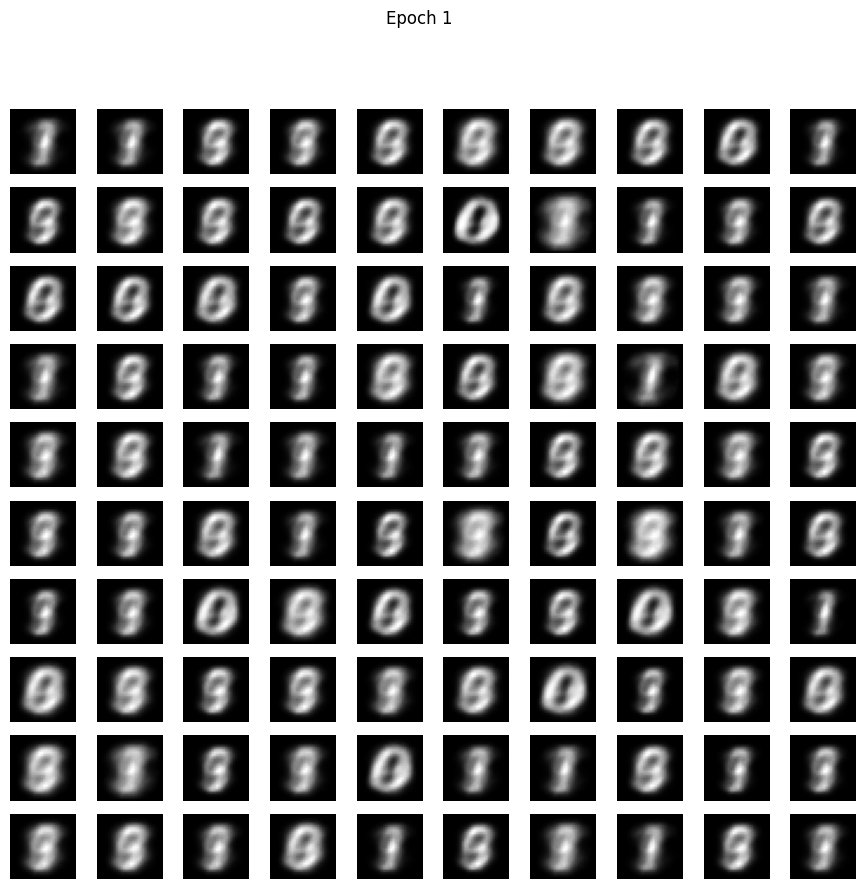

Epoch 2/5 Training ...: 100%|██████████| 1875/1875 [00:54<00:00, 34.23it/s, Loss: 218.18577178955078]


Epoch 2/5 - Train Loss: 228.5662430501302


Epoch 2/5 Testing ...: 100%|██████████| 313/313 [00:00<00:00, 399.22it/s]


Epoch 2/5 - Test Loss: 216.84977868418343, Recon: 210.69103097153928, KL: 6.15874803409028


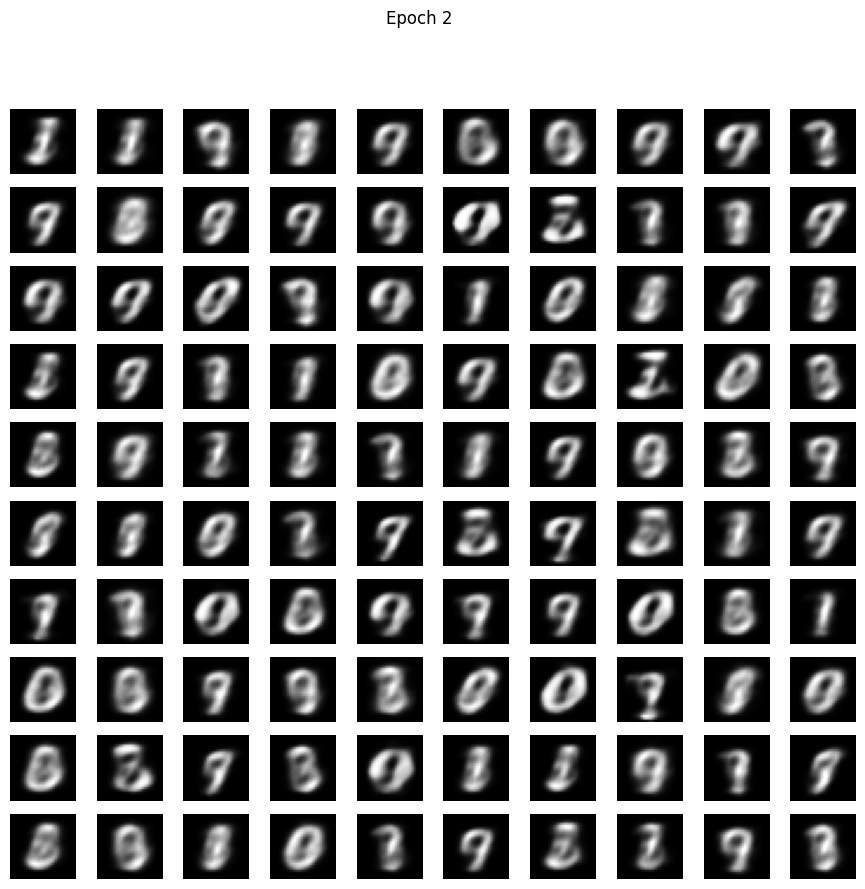

Epoch 3/5 Training ...: 100%|██████████| 1875/1875 [00:54<00:00, 34.12it/s, Loss: 209.83313903808593]


Epoch 3/5 - Train Loss: 211.66628919270832


Epoch 3/5 Testing ...: 100%|██████████| 313/313 [00:00<00:00, 358.39it/s]


Epoch 3/5 - Test Loss: 208.60858334672338, Recon: 201.39796681754504, KL: 7.210616166599261


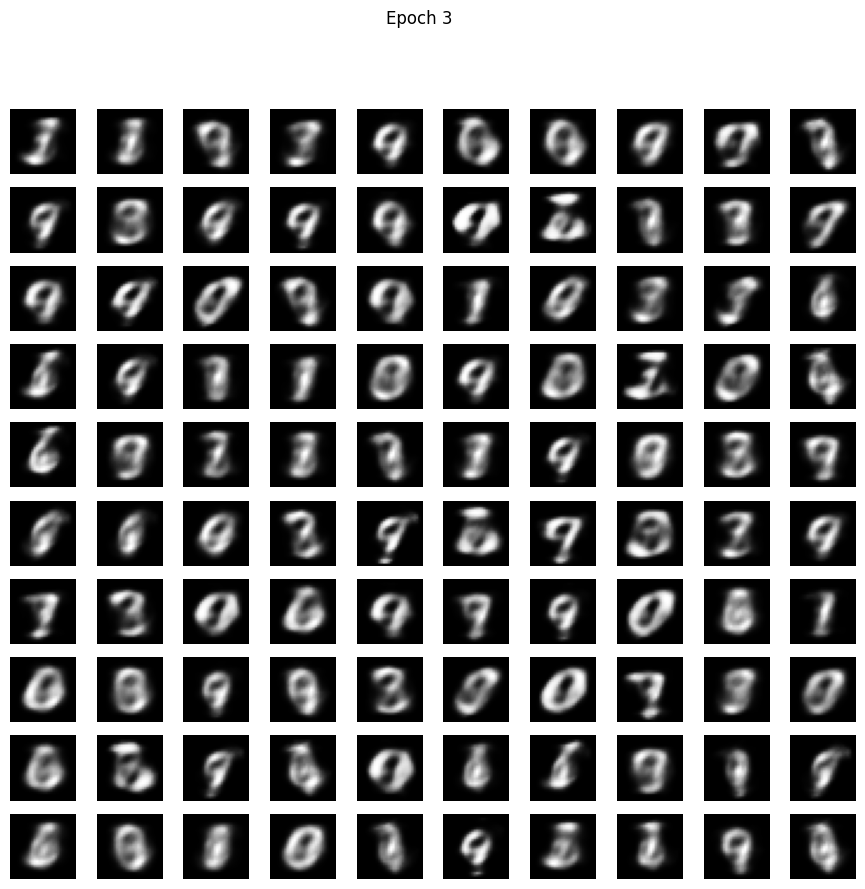

Epoch 4/5 Training ...: 100%|██████████| 1875/1875 [00:55<00:00, 33.70it/s, Loss: 200.7827278137207] 


Epoch 4/5 - Train Loss: 204.60125416666668


Epoch 4/5 Testing ...: 100%|██████████| 313/313 [00:00<00:00, 339.32it/s]


Epoch 4/5 - Test Loss: 199.62911197552665, Recon: 190.60895228766785, KL: 9.020159669577504


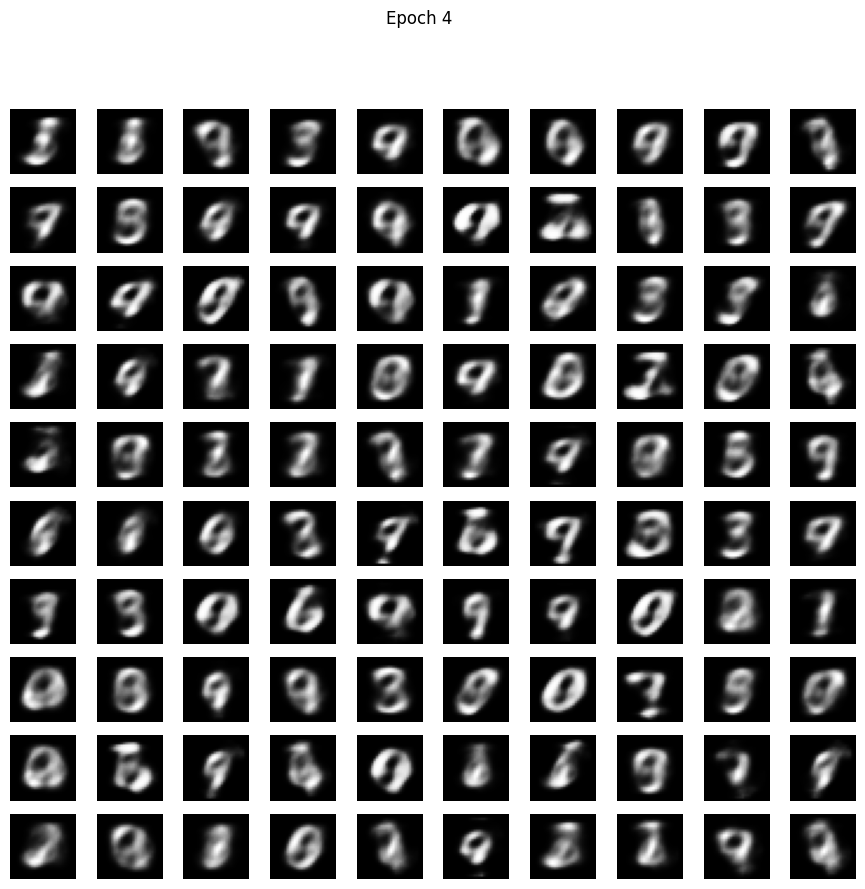

Epoch 5/5 Training ...: 100%|██████████| 1875/1875 [00:54<00:00, 34.25it/s, Loss: 193.78885986328126]


Epoch 5/5 - Train Loss: 197.6137046142578


Epoch 5/5 Testing ...: 100%|██████████| 313/313 [00:00<00:00, 385.94it/s]


Epoch 5/5 - Test Loss: 192.43563833023413, Recon: 182.32059349571935, KL: 10.11504494724944


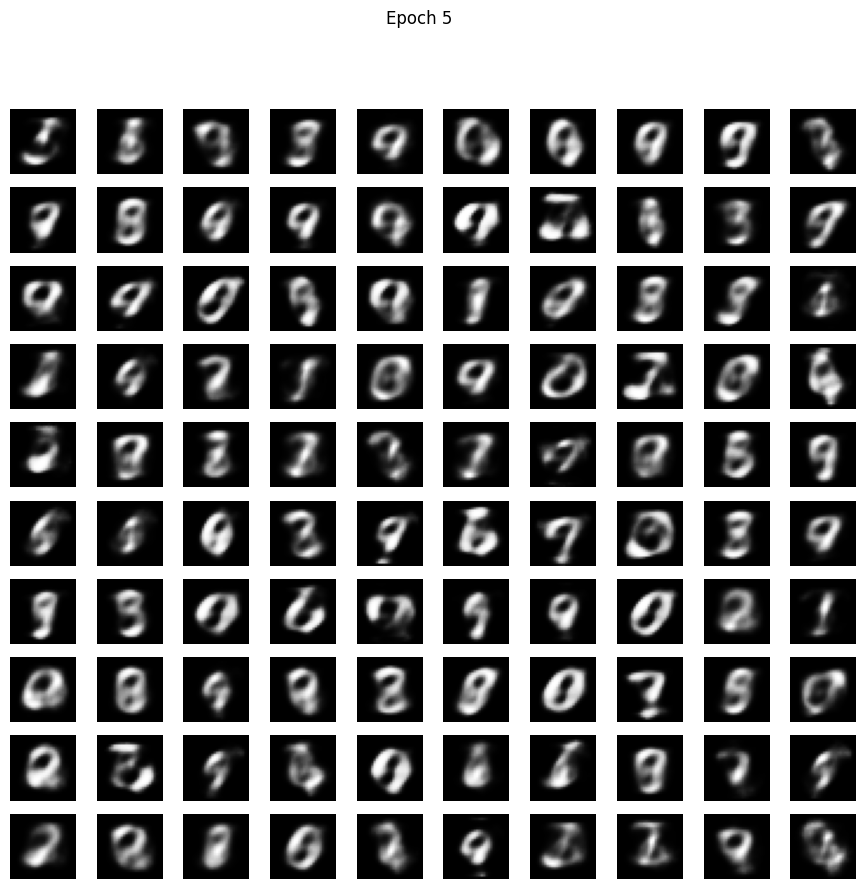

In [8]:
for e in range(1, epochs+1):
    
    train_step_history = []
    
    pbar = tqdm(train_ds.as_numpy_iterator(), total=train_ds.cardinality().numpy(), desc=f"Epoch {e}/{epochs} Training ...", colour="blue")
    for batch in pbar:
        key, _ = jax.random.split(key)
        batch = jnp.array(batch)
        loss, params, optimizer, opt_state = train_step(batch, params, key, optimizer, opt_state)
        train_step_history.append(float(loss))
        pbar.set_postfix_str(f"Loss: {sum(train_step_history[-100:]) / len(train_step_history[-100:])}")
        
    epoch_train_loss = sum(train_step_history)/len(train_step_history)
    print(f"Epoch {e}/{epochs} - Train Loss: {epoch_train_loss}")
    
    test_step_history_total = []
    test_step_history_kl = []
    test_step_history_recon = []
    pbar2 = tqdm(test_ds.as_numpy_iterator(), total=test_ds.cardinality().numpy(), desc=f"Epoch {e}/{epochs} Testing ...", colour="green")
    test_key = jax.random.PRNGKey(0)
    for batch in pbar2:
        test_key = jax.random.split(test_key)[0]
        batch = jnp.array(batch)
        loss = test_step(batch, params, test_key)
        total_loss, recon_loss, kl_loss = loss
        test_step_history_total.append(float(total_loss))
        test_step_history_kl.append(float(kl_loss))
        test_step_history_recon.append(float(recon_loss))

    epoch_test_loss = sum(test_step_history_total)/len(test_step_history_total)
    epoch_test_recon_loss = sum(test_step_history_recon)/len(test_step_history_recon)
    epoch_test_kl_loss = sum(test_step_history_kl)/len(test_step_history_kl)
    
    print(f"Epoch {e}/{epochs} - Test Loss: {epoch_test_loss}, Recon: {epoch_test_recon_loss}, KL: {epoch_test_kl_loss}")
    
    visualize(fixed_noise, params, e)